## plotting RIP.ie daily death data

* RIP.ie
* https://dmnfarrell.github.io/plotting/ireland-ripie-deaths

In [1]:
import pandas as pd
import pylab as plt
import numpy as np
import seaborn as sns
import matplotlib as mpl
import pylab as plt
import matplotlib.dates as mdates

pd.set_option('display.width', 150)
locator = mdates.AutoDateLocator(minticks=4, maxticks=10)
formatter = mdates.ConciseDateFormatter(locator)
sns.set_style("white")
sns.set_context('talk')

## generate and clean raw data

In [2]:
raw = pd.read_csv('ripie.csv',encoding='Latin-1')
print (len(raw))

raw['date'] = pd.to_datetime(raw.date,format='%d/%m/%y',errors='coerce')
raw = raw[~raw.date.isnull()]
raw = raw.sort_values('date')
raw['year'] = raw.date.dt.year
raw['month'] = raw.date.dt.month
raw['day'] = raw.date.dt.dayofyear
raw['week'] = raw.date.dt.weekofyear
raw = raw.drop_duplicates(subset=['date','name'])
print (len(raw))
raw.to_csv('ripie_processed.csv')


96913
74435


<ipython-input-2-46aa9830a164>:10: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  raw['week'] = raw.date.dt.weekofyear


In [4]:
x = raw[(raw.month==1) & (raw.year==2020)]
x.name.value_counts()[:10]
#x[x.name.str.contains('Kelly')]

O'Brien, John              3
Kelly, John                2
Keane, Tom                 2
Masterson, John            2
Dennehy, Michael (Mick)    2
Walsh, Martin              2
Byrne, Michael             2
Murphy, John               2
Flynn, Mary                2
Kennedy, Michael           2
Name: name, dtype: int64

In [5]:
bycounty = pd.pivot_table(raw, index='county',columns=['year'],values='name',aggfunc='size')
#bycounty.plot(kind='bar',figsize=(12,7))

## parse names

In [6]:
female=list(pd.read_csv('female_names.csv')['name'].str.lower())
def check_name(x):
    if type(x) is float:
        return
    if 'née' in x:
        return 'F'    
    s = x.split(',')[1].strip()
    #handle double names
    s = s.split()
    for n in s:       
        if n.strip("()").lower() in female:            
            return 'F'
    return 'M'
    
raw['sex'] = raw['name'].apply(check_name)
raw.sex.value_counts()

M    39224
F    35207
Name: sex, dtype: int64

year
2019    33122
2020    33842
2021     7467
dtype: int64


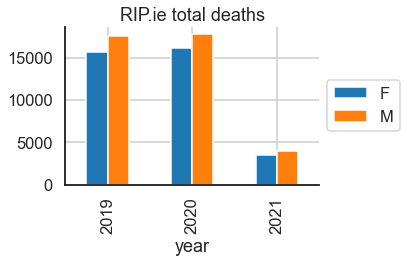

In [7]:
totals = pd.pivot_table(raw, index='year',columns='sex',values='name',aggfunc='size')
print (totals.sum(1))
ax=totals.plot(kind='bar',grid=True)
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5)) 
plt.title('RIP.ie total deaths')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_summary.png',dpi=100)

year
2019    33124.0
2020    33842.0
2021     7469.0
dtype: float64


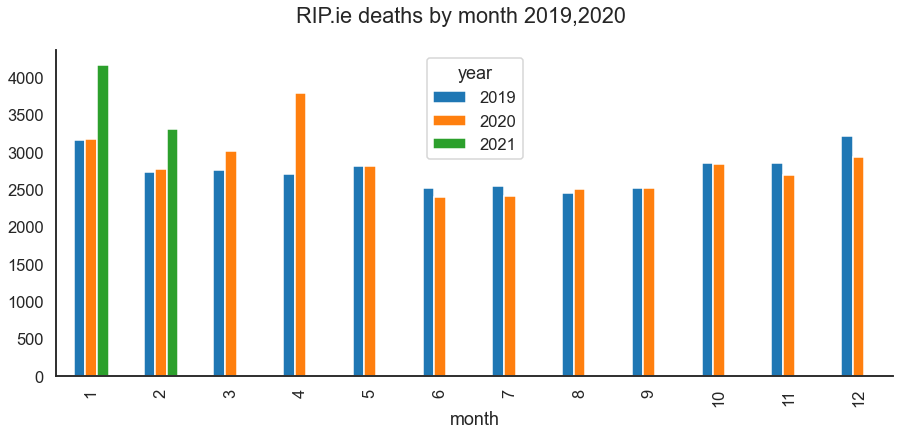

In [8]:
bymonth = pd.pivot_table(raw, index='month',columns='year',values='name',aggfunc='size')
print (bymonth.sum())
bymonth.plot(kind='bar',figsize=(15,6))
#bymonth.to_csv('rip_deaths_monthly.csv')
plt.suptitle('RIP.ie deaths by month 2019,2020')
sns.despine()
plt.savefig('ireland_deaths_ripie_bymonth.png',dpi=150)

    month  2020_GRO  2019_GRO  2019_RIP  2020_RIP    2021
0       1    2946.0      3041    3153.0    3168.0  4160.0
1       2    2676.0      2603    2727.0    2767.0  3309.0
2       3    2868.0      2672    2761.0    3008.0     NaN
3       4    3523.0      2502    2709.0    3787.0     NaN
4       5    2555.0      2651    2815.0    2808.0     NaN
5       6    2101.0      2388    2520.0    2401.0     NaN
6       7    2066.0      2321    2550.0    2408.0     NaN
7       8    2146.0      2314    2456.0    2509.0     NaN
8       9    2156.0      2411    2517.0    2516.0     NaN
9      10    2331.0      2581    2858.0    2842.0     NaN
10     11       NaN      2679    2848.0    2690.0     NaN
11     12       NaN      3060    3210.0    2938.0     NaN


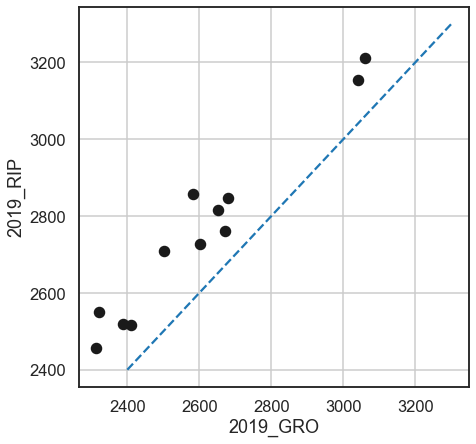

In [55]:
gro = pd.read_csv('gro_deaths.csv')
a=bymonth.reset_index()
a.columns=['month','2019','2020','2021']
b=gro.merge(a,on='month',suffixes=['_GRO','_RIP'])
#b.sum().plot(kind='bar',figsize=(15,6))
print (b)
f,ax=plt.subplots(1,1,figsize=(7,7))
b.plot(x='2019_GRO',y='2019_RIP',c='0.1',s=100,kind='scatter',grid=True,ax=ax)
ax.plot([2400, 3300], [2400, 3300], ls='--')

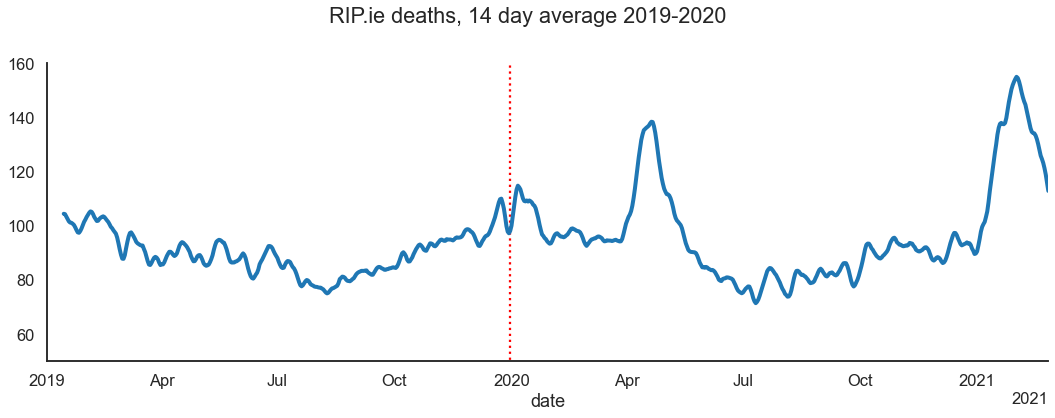

In [56]:
x = raw.groupby('date').size()
ax=x.rolling(14,win_type='hamming').mean().plot(lw=4,figsize=(15,6),ylim=(50,160))
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.vlines(pd.to_datetime('2019-12-31'),0,160,color='r',ls=':')
plt.suptitle('RIP.ie deaths, 14 day average 2019-2020')
sns.despine()
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_trend.png',dpi=150)

In [11]:
byday = pd.pivot_table(raw, index='day',columns='year',values='name',aggfunc='size')
byday.to_csv('rip_deaths_daily.csv')

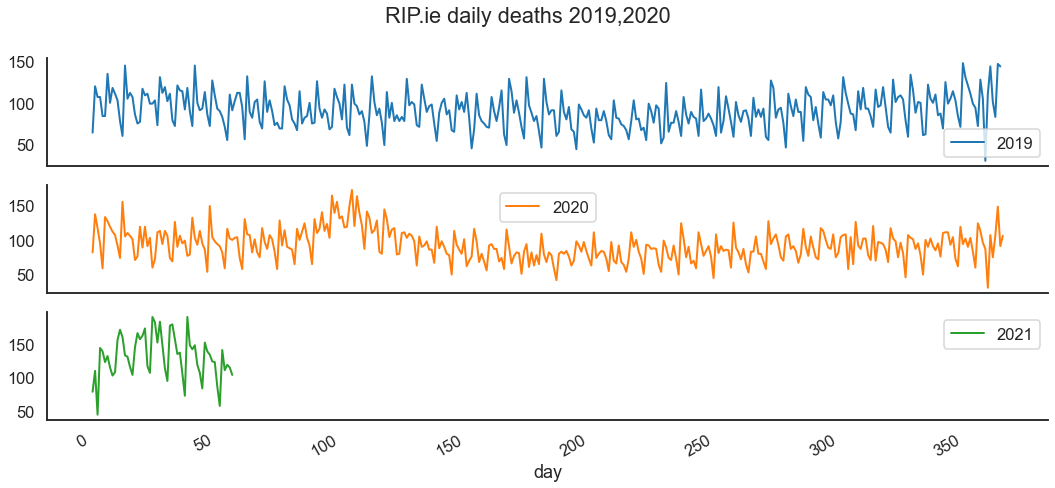

In [12]:
ax=byday.plot(figsize=(15,7),lw=2,subplots=True)
sns.despine()
plt.suptitle('RIP.ie daily deaths 2019,2020')
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_compared_raw.png',dpi=150)

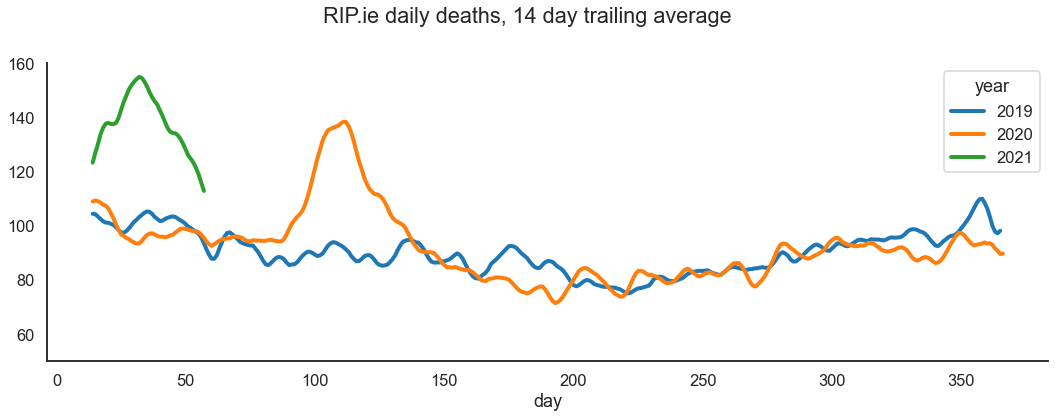

In [13]:
meanday = byday.rolling(window=14,win_type='hamming').mean()
meanday.plot(figsize=(15,6),ylim=(50,160),lw=4)
sns.despine()
plt.suptitle('RIP.ie daily deaths, 14 day trailing average')
plt.tight_layout()
plt.savefig('ireland_deaths_ripie_compared_mean.png',dpi=150)

<AxesSubplot:xlabel='day'>

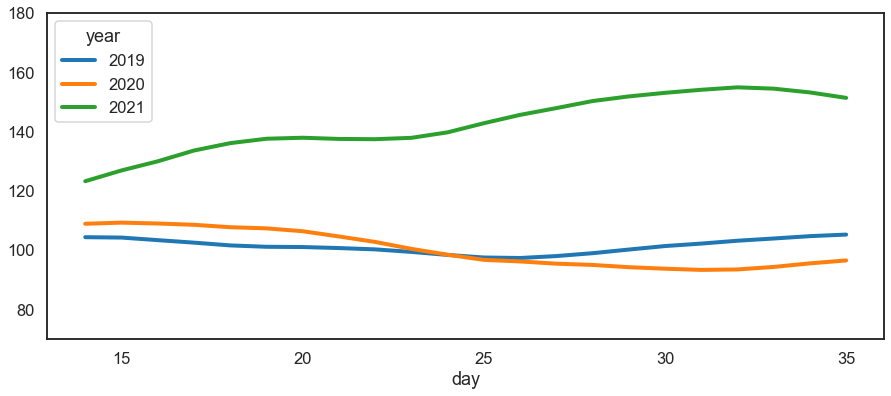

In [14]:
#single months only
x=meanday.loc[:35]
x.plot(figsize=(15,6),ylim=(70,180),lw=4)

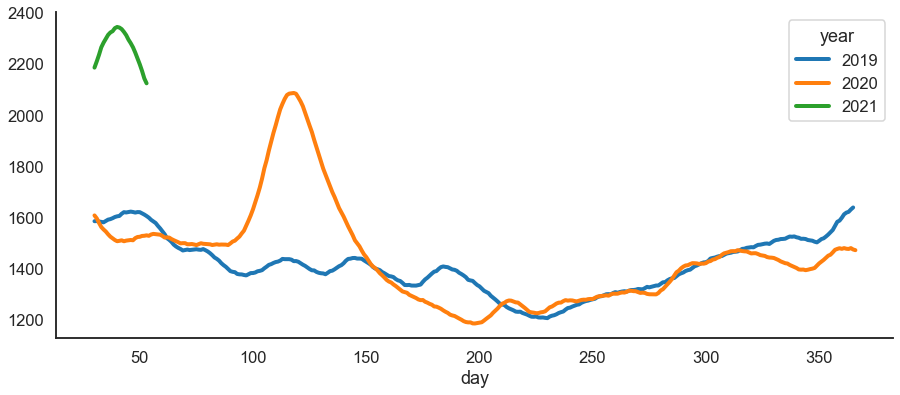

In [252]:
meanmonth = byday.rolling(window=30,win_type='hamming').sum()
meanmonth.plot(figsize=(15,6),lw=4)
sns.despine()

## aggregate days in long form for seaborn plots

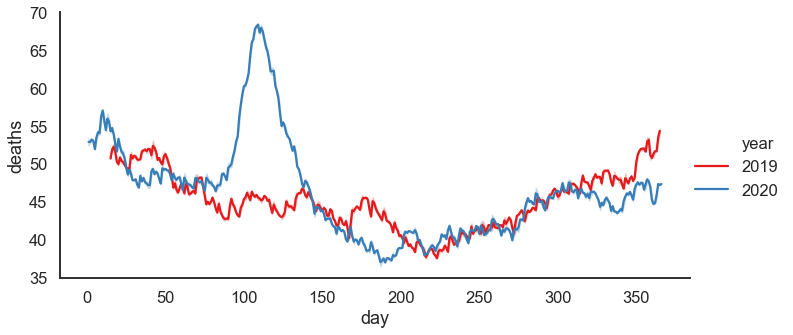

In [255]:
g = raw.groupby(['date','day','year','sex'],as_index=False).size()
g['deaths'] = g['size'].rolling(30).mean(win_type='hamming')
fg=sns.relplot(data=g,x='day',y='deaths',hue='year',kind='line',aspect=2,palette='Set1')

         date  dose 1  dose 2  dose1_diff  day
0  2021-01-07   15314       0       15314    7
1  2021-01-13   77303       0       61989   13
2  2021-01-17   94000       0       16697   17
3  2021-01-20  121900       0       27900   20
4  2021-01-27  147700   13800       25800   27
5  2021-01-31  150500   49300        2800   31
6  2021-02-04  152200   67000        1700   35
7  2021-02-07  153654   86833        1454   38
8  2021-02-08  154900   88453        1246   39
9  2021-02-11  171239   89834       16339   42
10 2021-02-16  175238   89999        3999   47
11 2021-02-17  180192   91750        4954   48
12 2021-02-18  182193   98388        2001   49
13 2021-02-19  187893  105859        5700   50
14 2021-02-20  197609  113291        9716   51
15 2021-02-21  205955  120520        8346   52
16 2021-02-22  214384  126320        8429   53
17 2021-02-23  219899  130423        5515   54
18 2021-02-24  222073  131898        2174   55
19 2021-02-25  226291  133325        4218   56
20 2021-02-26

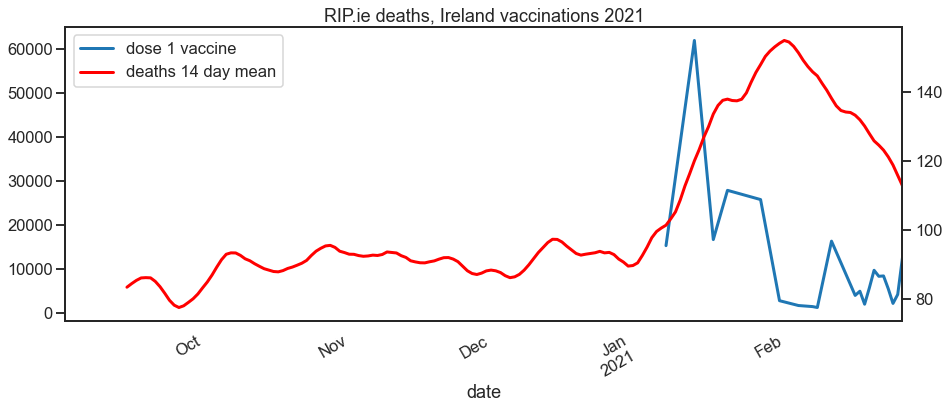

In [47]:
#https://www.irishtimes.com/news/health/covid-19-vaccine-tracker-what-s-available-in-the-republic-of-ireland-and-what-else-is-coming-1.4481095
vacc = pd.read_csv('vaccine_rollout.csv')
vacc['date']=pd.to_datetime(vacc.date,format='%d/%m/%Y')
vacc['day']=vacc.date.dt.dayofyear
print (vacc)

fig,ax=plt.subplots(1,1,figsize=(15,6))
l1=vacc.plot(x='date',y=['dose1_diff'],lw=3,ax=ax,legend=False)
x = raw[raw.date>'09-01-2020'].groupby('date').size()

x=x.rolling(14,win_type='hamming').mean()
l2=x.plot(c='r',ax=ax.twinx(),lw=3)
plt.title('RIP.ie deaths, Ireland vaccinations 2021')
plt.legend([l1.get_lines()[0],l2.get_lines()[0]],['dose 1 vaccine','deaths 14 day mean'],)
plt.savefig('vac_rollout.png')

<AxesSubplot:xlabel='year,week'>

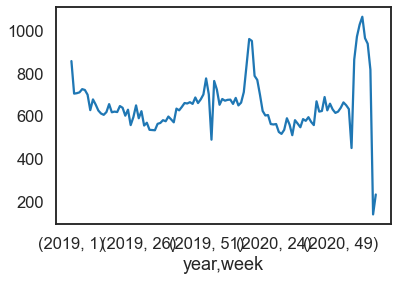

In [330]:
#x.plot(x='date',kind='bar')
g=raw.groupby(['year','week']).size()
g.plot()

## plot with covid deaths

In [80]:
covd = pd.read_csv('http://opendata-geohive.hub.arcgis.com/datasets/d8eb52d56273413b84b0187a4e9117be_0.csv?outSR={"latestWkid":3857,"wkid":102100}')
covd['date'] = pd.to_datetime(covd['Date'], infer_datetime_format=True)
cols=['date','ConfirmedCovidCases','HospitalisedCovidCases','ConfirmedCovidDeaths']
covd=covd[cols]

In [256]:
covd['day'] = covd.date.dt.dayofyear
covd['year'] = covd.date.dt.year

X = raw.groupby('date').size().reset_index()
X=X.rename(columns={0:'deaths'})
M = X.merge(covd,on='date',how='inner')
M['difference'] = M.deaths - M['ConfirmedCovidDeaths']
M['mean deaths'] = M['deaths'].rolling(14).mean()
M['covid deaths'] = M['ConfirmedCovidDeaths'].rolling(14).mean()

In [257]:
M

,date,deaths,ConfirmedCovidCases,HospitalisedCovidCases,ConfirmedCovidDeaths,day,year,difference,mean deaths,covid deaths
0,2020-02-29,74,1,NaN,0,60,2020,74,NaN,NaN
1,2020-03-03,108,1,NaN,0,63,2020,108,NaN,NaN
2,2020-03-04,107,4,NaN,0,64,2020,107,NaN,NaN
3,2020-03-05,82,7,NaN,0,65,2020,82,NaN,NaN
4,2020-03-06,101,5,NaN,0,66,2020,101,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
300,2020-12-27,75,744,5840.0,4,362,2020,71,91.714286,5.714286
301,2020-12-28,106,765,5873.0,1,363,2020,105,90.785714,5.642857
302,2020-12-29,148,1546,5898.0,9,364,2020,139,94.642857,5.714286
303,2020-12-30,91,1718,5932.0,13,365,2020,78,93.857143,6.214286


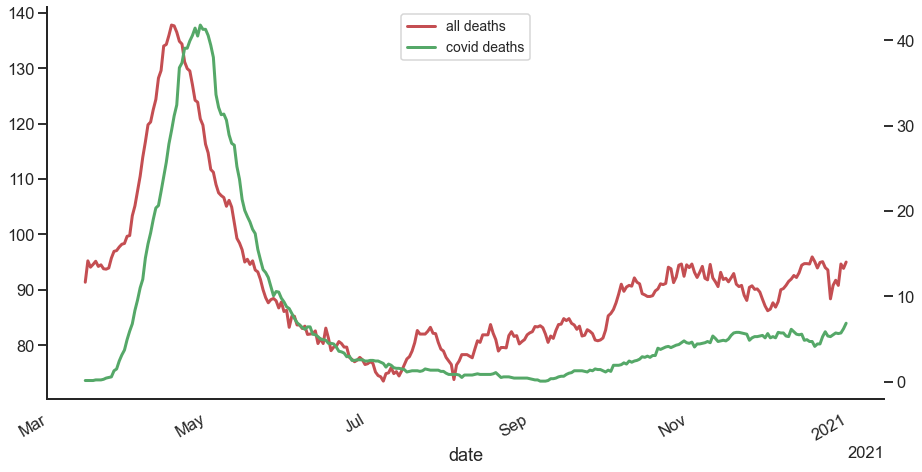

In [258]:
f,ax=plt.subplots(1,1,figsize=(15,8))
ax1=ax.twinx()
M.plot(x='date',y='mean deaths',figsize=(15,8),c='r',lw=3,legend=False,ax=ax)
M.plot(x='date',y='covid deaths',figsize=(15,8),c='g',lw=3,legend=False,ax=ax1)
ax.xaxis.set_major_locator(locator)
ax.xaxis.set_major_formatter(formatter)
ax.legend([ax.get_lines()[0],ax1.get_lines()[0]],['all deaths','covid deaths'],loc=9,fontsize=14)
sns.despine()
plt.savefig('ireland_deaths_ripie_covid.png',dpi=150)

In [ ]:
sm = M[M.date>'2020-06-01']
ax=M.plot('date',y=['difference','ConfirmedCovidDeaths'],kind='bar',stacked=True,figsize=(20,3))
ax.xaxis.set_major_locator(locator)


## curve fitting

[0.23055033 2.00249511]


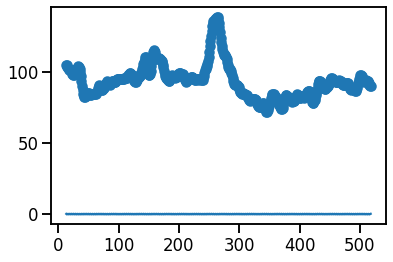

In [323]:
from scipy import optimize

def test_func(x, a, b):
    return a * np.sin(b * x)

T = raw.groupby('date').size().reset_index()
T=T.rolling(14,win_type='hamming').mean().dropna()
x_data = T.index
y_data = T[0]

params, params_covariance = optimize.curve_fit(test_func, x_data, y_data,
                                               p0=[1, 2])
print(params)
plt.scatter(x_data, y_data, label='Data')
plt.plot(x_data, test_func(x_data, params[0], params[1]),
         label='Fitted function')

In [300]:
print (byday)

year   2019   2020
day               
1      64.0   82.0
2     120.0  137.0
3     107.0  117.0
4     107.0   95.0
5      84.0   59.0
..      ...    ...
362   101.0   75.0
363    83.0  106.0
364   147.0  148.0
365   144.0   91.0
366     NaN  106.0

[366 rows x 2 columns]
